# PPFQ

## Data Mining

-48-

Buscamos patrones o indicadores que nos brinden señales.

Ejemplo: dos indicadores

objetivo: investigar entre muchos indicadores, correlaciones contra el precio, o el retorno futuro del mismo.

"Testear bot de trading del tipo trend-following, con cruce de medias y oscilador tipo RSI."

In [16]:
from dotenv import load_dotenv
import os
from apps.forex_api import  alpha_vantage_fx_api
import pandas as pd
import seaborn as sns


load_dotenv()
TOKEN = os.environ["TOKEN_AV"]
# data = alpha_vantage_fx_api("FX_WEEKLY", "EUR", "USD", TOKEN)

In [17]:
# data.to_csv('data-weekly-raw.csv')

data = pd.read_csv("data-weekly-raw.csv", index_col=0)
data

,1. open,2. high,3. low,4. close
2022-10-28,0.98832,1.00937,0.98047,0.99630
2022-10-21,0.97223,0.98755,0.97030,0.98610
2022-10-14,0.97382,0.98086,0.96290,0.97190
2022-10-07,0.97954,0.99997,0.97250,0.97410
2022-09-30,0.96739,0.98539,0.95320,0.98003
...,...,...,...,...
2003-10-03,1.14670,1.17680,1.13930,1.15760
2003-09-26,1.14110,1.15340,1.14100,1.14690
2003-09-19,1.12580,1.13900,1.11320,1.13900
2003-09-12,1.10950,1.13240,1.10420,1.12880


In [18]:
# PARAMETROS INCIALES
ruedas = 14
par = "EUR/USD"
fast, slow = 10, 70
sigma = 40

fw = 10, 20

features = [f"Cruce_{fast}_{slow}", "rsi", f"sigma_{sigma}"] # atributo dinámico
forwards = [f"fw_{i}" for i in fw] # atributo preseteado, dinámico

In [19]:
# AJUSTE DE DATA
new_labels = ['Open', "High", "Low", "Close"]

data.rename(dict(zip(data.columns, new_labels)), axis=1, inplace=True)

data = data.iloc[-1::-1]


In [20]:
# cruce de SMAs
def cruce_sma_fast_slow(data, fast, slow):
    dataux = pd.DataFrame()
    dataux[f"SMA_{fast}"] = data.loc[:, "Close"].rolling(fast).mean()
    dataux[f"SMA_{slow}"] = data.loc[:, "Close"].rolling(slow).mean()
    data.loc[:, f"Cruce_{fast}_{slow}"] = dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] *100 -100
    return data

data = cruce_sma_fast_slow(data, fast, slow)


# calculo rsi
def rsi(data, ruedas):
    dataux = pd.DataFrame()
    dataux["dif"] = data.Close.diff()
    dataux["win"] = np.where(dataux["dif"] > 0, dataux["dif"], 0)
    dataux["loss"] = np.where(dataux["dif"] < 0, abs(dataux["dif"]), 0)
    dataux["ema_win"] = dataux.win.ewm(alpha=1/ruedas).mean()
    dataux["ema_loss"] = dataux.loss.ewm(alpha=1/ruedas).mean()
    dataux["rs"] = dataux.ema_win / dataux.ema_loss
    data.loc[:, "rsi"] = 100 - (100 / (1+ dataux.loc[:, "rs"]))
    return data

data = rsi(data, ruedas)


# Calculo volatilidad
def volatilidad(data, sigma):
    data.loc[:, "variacion"] = data.loc[:, "Close"].pct_change() *100
    data.loc[:, f"sigma_{sigma}"] = data.loc[:, "variacion"].rolling(sigma).std() * (sigma **0.5)
    return data

data = volatilidad(data, sigma)


def forward(data, fw):
    for step in fw:
        data[f"fw_{step}"] = (data.Close.shift(-step) / data.Close.shift() -1) *100
    return data

data = forward(data, fw)


def ajustar_datos(data, features):
    data = data.iloc[:, 3:].dropna()
    data.loc[:, features] = data.loc[:, features].shift()
    return data.round(4)

data = ajustar_datos(data, features)

data

C:\Users\aguST\AppData\Local\Temp\ipykernel_18092\763269664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, f"Cruce_{fast}_{slow}"] = dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] *100 -100
C:\Users\aguST\AppData\Local\Temp\ipykernel_18092\763269664.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "rsi"] = 100 - (100 / (1+ dataux.loc[:, "rs"]))
C:\Users\aguST\AppData\Local\Temp\ipykernel_18092\763269664.py:29: SettingWithCopyWarning: 
A value is trying to be set

,Close,Cruce_10_70,rsi,variacion,sigma_40,fw_10,fw_20
2004-12-31,1.3552,NaN,NaN,0.2070,NaN,-0.5250,-7.2020
2005-01-07,1.3050,7.4995,72.9984,-3.7043,7.6762,-1.6898,-7.2388
2005-01-14,1.3107,7.4742,56.1785,0.4368,8.6492,-0.7280,-6.3065
2005-01-21,1.3042,7.3816,57.3793,-0.4959,8.6378,-1.5335,-7.4540
2005-01-28,1.3036,7.2276,55.5112,-0.0460,8.6023,-0.9354,-5.8197
...,...,...,...,...,...,...,...
2022-05-13,1.0412,-6.6644,26.9029,-1.3174,6.3059,-3.2319,-7.1150
2022-05-20,1.0560,-6.9008,24.1897,1.4214,6.3605,-1.7979,-6.4445
2022-05-27,1.0732,-7.0290,32.0479,1.6259,6.5665,-3.5890,-7.9640
2022-06-03,1.0719,-7.1391,39.8391,-0.1183,6.8061,-4.4140,-8.1133


[(-10.0, 10.0)]

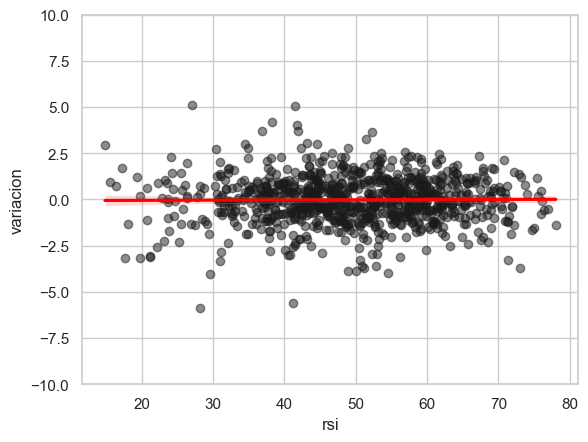

In [21]:
# Look-Ahead Bias
"""Es necesario tomar todos los indicadores y atrasarlos un día, porque "hoy operamos con los indicadores de ayer" """


"""
La tarea a realizar es determinar si existe correlación entre las features y la fluctuación del precio.
También identificar si generan algún tipo de clasificación diferenciable.
""";

sns.set(style="whitegrid")
g = sns.regplot(x="rsi", y="variacion", data=data, line_kws={"color":"red"},
                scatter_kws={"color":"k", "alpha":.5})

g.set(ylim=(-10,10))                

### Correlación features vs variación

-51-

In [22]:
for feature in features:
    r2 = data[feature].corr(data.variacion)
    print (f"El r2 con {feature} es {r2:.2f}")

El r2 con Cruce_10_70 es -0.04
El r2 con rsi es 0.01
El r2 con sigma_40 es 0.05


In [23]:
# TODO: la variable "variacion" está hardcodeada, esto se soluciona creando una clase
data.corr().loc[['variacion'] + forwards, features].round(2)

,Cruce_10_70,rsi,sigma_40
variacion,-0.04,0.01,0.05
fw_10,-0.13,0.11,0.17
fw_20,-0.24,0.09,0.19


### Clasificación diferenciable

-55-

La cuestión es separar los variacion expost (fw) si el indicador refleja alguna diferencia o no.

In [24]:
data['variacion_tipo'] = np.where(data.variacion > 0, "Up", "Down")

medias = data.groupby("variacion_tipo").mean().loc[:, features].round(2)
desvios = data.groupby("variacion_tipo").std().loc[:, features].round(2)

print (f"Medias según clasificación \n{medias}\n")
print (f"Desvíos según clasificación \n{desvios}\n")

Medias según clasificación 
                Cruce_10_70    rsi  sigma_40
variacion_tipo                              
Down                  -0.17  49.59      7.70
Up                    -0.27  49.27      7.73

Desvíos según clasificación 
                Cruce_10_70    rsi  sigma_40
variacion_tipo                              
Down                   4.94  11.92      2.49
Up                     5.20  12.29      2.40



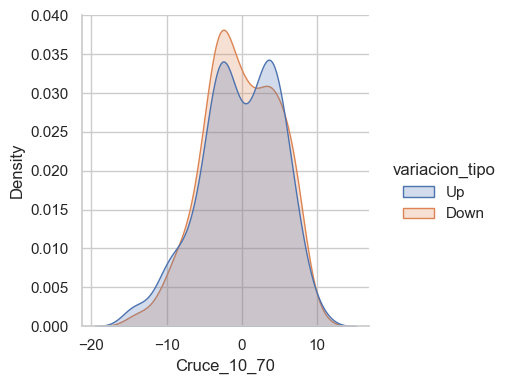

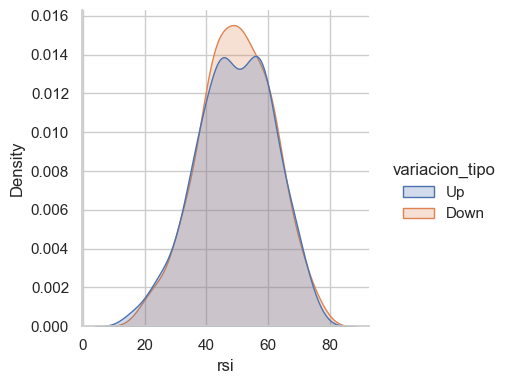

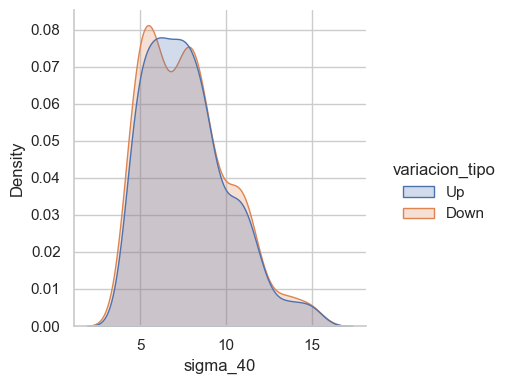

In [26]:
for feature in features:
    sns.displot(data, x=feature, hue='variacion_tipo', kind="kde", height=4, fill=True)

## Construcción de indicadores

-57-